# Monitor Envs, Recording Tools, and Evaluating Model Performance in Custom Envs

In this notebook, I'll be learning how to record model performance using the *Monitor* wrapper for gymnasium **Envs**. Stable-Baselines-3 (SB3) has an excellent suite of tools for recording and plotting model performance, designed to work with the *Monitor* Env wrapper. The plan for this Notebook is to accomplish the following:

1. Wrap an existing Gymnasium Env in the Monitor Wrapper
2.  Log the performance of an SB3 model during training in that environment
3.  Save the log to a separate folder in this directory
4.  Use the log data to plot model performance over training timesteps using SB3 tools.
5.  Wrap my custom TimedColorGame-V0 Env in the Monitor Wrapper and register it as TimedColorGame-v1
6.  Record the performance of an SB3 model in my Env and save in a local folder.
7.  Use the SB3 plotting tools to plot model performance over training timesteps for the Timed Color Game.
8.  Record the performance of multiple models over multiple timesteps and plot their performance in a single Graph using SB3 tools
9.  Streamline this process into a simple workflow or even a function I can recycle for future model testing.

#### 1. Wrap a Gym Env in the Gymnasium *Monitor* Wrapper 

For this task, I'll be following a simple tutorial provided by SB3, which is publically available here: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/monitor_training.ipynb#scrollTo=pUWGZp3i9wyf . Let's go!

In [1]:
#IMPORTS
import os
from typing import Optional
#Gymnasium and base Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
#SB3 Imports
from stable_baselines3 import A2C, PPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback

In [2]:
#We're Creating a Custom Callback function for saving a model after the ideal number of training timesteps as per the tutorial.
#This class mimics the built-in SB3 EvalCallback class.
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for savig a model based on the training reward (the check is done every `check_freq` steps)
    In practice, we recommend using `EvalCallback`.

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved. Must contain the file created by the
    `Monitor` wrapper.
    :oaram verbose: (int)
    """
    def __init__(self,check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir,"best_model")
        self.best_mean_reward = -np.inf
    
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    #The _on_step() function of the call-back adds itself to the step() function of the Env when it is used to train a model. This
    # allows us to make additional checks and log additional data about model performance every once in awhile.
    def _on_step(self) -> bool:
        # We only perform the function body every n_calls using this modular filter.
        # This way, each time the body of the functio runs, there is actually new data to collect.
        if self.n_calls % self.check_freq == 0:
            #Retrieve training reward. It looks like this function is actually collecting data from the log_dir.
            # I wonder where in the function body it logs the info there.
            x, y = ts2xy(load_results(self.log_dir),"timesteps")
            if len(x) > 0:
                #Mean training reward over the past 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
                    #New best model, you could save the agent here
                    if mean_reward > self.best_mean_reward:
                        self.best_mean_reward = mean_reward
                        #Example ofr saving best model
                        if self.verbose > 0:
                            print(f"Saving new best model to {self.save_path}.zip")
                        self.model.save(self.save_path)

        return True

In [4]:
# Create log dir
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log/"
os.makedirs(log_dir,exist_ok=True)

## Testing out the Monitor wrapper and logging on a preset Gymnasium Env

In [4]:
#Create Env and wrap in Monitor wrapper
env = gym.make("FrozenLake-v1")
env = Monitor(env, log_dir)
# Create RL model
model = A2C('MlpPolicy', env, verbose=0)
# Train the agent
model.learn(total_timesteps=100000, callback=EvalCallback(env, best_model_save_path=log_dir, log_path=log_dir, eval_freq=20000), progress_bar=True)

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Eval num_timesteps=20000, episode_reward=0.20 +/- 0.40

Episode length: 35.80 +/- 29.36

New best mean reward!

Eval num_timesteps=40000, episode_reward=0.20 +/- 0.40

Episode length: 29.80 +/- 18.35

Eval num_timesteps=60000, episode_reward=0.00 +/- 0.00

Episode length: 18.40 +/- 9.83

Eval num_timesteps=80000, episode_reward=0.60 +/- 0.49

Episode length: 49.00 +/- 33.31

New best mean reward!

Eval num_timesteps=100000, episode_reward=0.40 +/- 0.49

Episode length: 48.20 +/- 33.86

### First 3 steps down!

I had trouble with the **Box-2d** Envs that were used in the tutorial, first with installing the package (I had to download Microsofts *C++ Build Tools* for Visual Studio Code before I could even install the **Box-2d** package), then with errors resulting from running the **Box-2d** Envs themselves. I couldn't figure out what, if anything, I was doing wrong. My guess is that my install is somehow out-of-date with the current version of **Gymnasium**. 

However, the **Embodied Communication Game** will be run in a Grid-World Env, so as long as I can get logging to work properly with Grid-World Envs I should be fine. And it looks like logging works great for the **A2C** model in the **FrozenLake** environment.

Now to figure out how to plot the model performance.

### Plotting model performance

SB3 has a built in plotter, `stable_baselines3.common.results.results_plotter`. However, in accordance with the tutorial, I'm going to first design a custom plotting function to gain a better understanding of how to plot the performance of the SB3 models. My custom function should end up behaving identically to the **results_plotter** function.

In [2]:
#A function to smooth the model performance graph by taking a moving average of performance.
def moving_average(values, window, gaussian = False):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    #We create the vector to multiply each value by to get the moving average. Essentially a vector of length n
    # in which each weight is 1/n.
    kernel = np.repeat(1.0, window) / window
    if (gaussian == True) :
        if window % 2 == 0:
            window+=1
        x = np.arange(-(window // 2), window // 2 + 1)
        kernel = np.exp(-(x ** 2) / (2 * window ** 2))
        kernel = kernel / np.sum(kernel)
    
    #The convolve function iteratively multiplies the first n values in the values array by the weights array.
    # with the given weights array, it essentially takes the moving average of each N values in the values array.
    return np.convolve(values, kernel, "valid")

def plot_results(log_folder, x_range = None, smoothing = True, window = 100, gaussian = True, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the resFults to plot
    :param x_range: (str) the range of the plot on the X-axis
    :param smoothing: (bool) whether to use smoothing on the learning curve
    :param window: (int) the size of the smoothing kernel
    :param gaussian: (bool) whether to use a gaussian or flat smoothing convolution kernel
    :param title: (str) the title of the task to plot
    """

    x, y = ts2xy(load_results(log_folder), "timesteps")
    if smoothing is True:
        y = moving_average(y, window = window, gaussian = gaussian)
    x = x[(len(x) - len(y)):]
    # Plot
    plt.plot(np.arange(len(y)),y)
    plt.xlabel("# of Training Timesteps")
    plt.ylabel("Mean Reward")
    plt.title(title + f"Smoothed, window-size = {window}")
    plt.show()

def plot_multi(log_folders, labels, x_range = None, smoothing = True, window = 100, gaussian = False, title="Learning Curve "):
    """
    plot the results

    :param log_folders: (str) the save locations of the results for each line in the multi-line plot
    :param labels: The labels of each line in the multi-line plot.
    :param x_range: (str) the range of the plot on the X-axis
    :param smoothing: (bool) whether to use smoothing on the learning curve
    :param window: (int) the size of the smoothing kernel
    :param gaussian: (bool) whether to use a gaussian or flat smoothing convolution kernel
    :param title: (str) the title of the task to plot
    """
    for i, log_folder in enumerate(log_folders):
        x, y = ts2xy(load_results(log_folder), "timesteps")
        if smoothing is True:
            y = moving_average(y, window = window, gaussian = gaussian)
        # Truncate x
        x = x[(len(x) - len(y)):]
        plt.plot(x,y, label = labels[i])
    # if x_range is not None:
    #     plt.xlim(x_range[0],x_range[1])
    plt.xlabel("# of Training Timesteps")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.title(title + f"Smoothed, window-size = {window}")
    plt.show()

In [4]:
class SimpleColorGame(gym.Env):
    # Initializes the Env, including observation space and action space. This one initializes the Observation space as a grid
    # of boxes with colors assigned to them, and the action space as the movement of the agent along the grid.
    def __init__(self, size=2, step_limit=200):
        # The size of one side of the square grid. It will be NxN squares in area, where N is self._size
        self._size = size
        self._num_colors = size**2

        # This is a time limit on the number of steps the agent is allowed to take in the game. This is necessary to
        # prevent the game from running forever if the agent's policy prevents it from moving or reaching the target.
        self._step_limit = step_limit
        # Integer to keep track of the number of steps taken in a particular iteration of the game
        self._step_count = 0

        # The agent location is stored inside of a local variable.
        self._agent_location = np.array([-1, -1], dtype=np.int32)

        # The colors of the boxes are also stored in a local variable. These colors are randomized on start-up. For this
        # version of the game, I will substitute integer values for colors.
        self._square_colors = np.arange(self._num_colors).reshape(size, size)

        # The target color will be a random number between 1 and 4. This number will be initialized during the reset() method.
        self._target_color = np.random.randint(0, self._num_colors)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent location": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "square colors": gym.spaces.Box(
                    0, self._num_colors - 1, shape=(size, size), dtype=int
                ),
                "target color": gym.spaces.Discrete(self._num_colors),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(4)

        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
        }

    # Helper method used to get the observation from the state, useful in reset and step methods. This version returns
    # the properties of agent location, square colors, and the target color.
    def _get_obs(self):
        return {
            "agent location": self._agent_location,
            "square colors": self._square_colors,
            "target color": self._target_color,
        }

    # Helper method used to get auxiliary information from the state. Currently returns nothing.
    def _get_info(self):
        info = {"info": None}
        return info

    # Helper method for calculating the reward from the state. This will be useful as I can override it in child classes.
    def _get_reward(self):
        reward = (
            1
            if (self._square_colors[tuple(self._agent_location)] == self._target_color)
            else 0
        )
        return reward

    # Reset the environment to an initial configuration. The initial state may involve some randomness, so the seed argument
    # is used to guarantee an identical initial state whenever reset() is called with that seed. Options is a dict containing
    # any additional parameters we might want to specify during the reset.
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):

        # Firstly, we will call this method to seed self.np_random with the seed argument if given.
        super().reset(seed=seed)

        # Reset the step count to 0 for the new iteration of the game
        self._step_count = 0

        # Now randomly generate a starting location for the agent using self.np_random. We generate an array of size two
        # representing the agent's starting coordinates.
        self._agent_location = self.np_random.integers(0, self._size, size=2)

        # Generate a random permutation of the square colors, and reshape them into a sizeXsize grid.
        self._square_colors = self.np_random.permutation(self._num_colors).reshape(
            self._size, self._size
        )

        # Now we generate the target color, which is a random integer from 0 to self._num_colors inclusive.
        self._target_color = self.np_random.integers(0, self._num_colors)

        # Now we can return the observation and auxiliary info
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    # Takes an action as input and updates the state of the Env according to that Action. Step then returns an observation
    # containing the new Env state, as well as some other additional variables and info.
    def step(self, action):
        # First, iterate the step count by one
        self._step_count += 1

        # Next, we convert our action to a direction.
        direction = self._action_to_direction[action]

        # Then we add the direction coordinates to the agend coordinates to get the new agent location. We must clip the
        # agent location at the Box boundary, so the agent's coordinates are within 0 and self._size-1.
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self._size - 1
        )

        # Now we terminate the game and give the agent a reward if the square it's standing on is the target color.
        terminated = (
            self._square_colors[tuple(self._agent_location)] == self._target_color
        )

        # We also truncate the game if self._step_count > self._step_limit.
        truncated = self._step_count > self._step_limit

        # Reward is 1 if we are on the target color square, otherwise 0
        reward = self._get_reward()

        # Finally, use the helper functions to generate Obs and Info.
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info


# Now let's register this environment with a namespace and try calling gym.make on it later
gym.register(id="SimpleColorGame-v0", entry_point=SimpleColorGame)

# I'll make this class extend the SimpleColorGame class. We just want to modify the reward function to subtract 0.1 for each step taken.
class TimedColorGame(SimpleColorGame):
    # Override the _get_reward() method to subtract 1/self._step_limit from the normal reward. This creates an incentive to reach the target
    # square quickly.
    def _get_reward(self):
        reward = (
            (1.0 - self._step_count / self._step_limit)
            if (self._square_colors[tuple(self._agent_location)] == self._target_color)
            else 0
        )
        return reward


gym.register(id="TimedColorGame-v0", entry_point=TimedColorGame)

In [7]:
#I have time so I'll train the PPO model on the 3x3 grid over many timesteps.
env = gym.make("TimedColorGame-v0", size=3)
env = Monitor(env, log_dir)

mPPO = PPO("MultiInputPolicy",env,verbose=0)
mPPO.learn(500000, progress_bar=True)

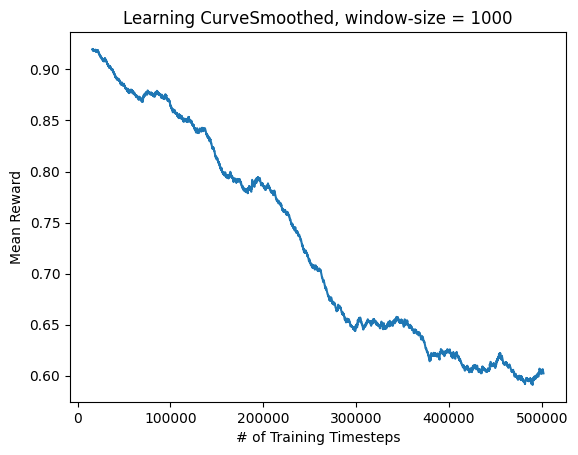

In [15]:
plot_results(log_dir, window=1000)

### Weird results

The last time I ran this the model improved significantly over the total training time, but this version of the model actually got worse after 500,000 timesteps.

### Time to try plotting multiple models' performances with the built-in results_plotter class.

In [3]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log/"
task = "TCG-vO-s3/"
mPPO_monitor_dir = f"{log_dir}{task}PPO/"
mA2C_monitor_dir = f"{log_dir}{task}A2C/"

# env_PPO = Monitor(gym.make("TimedColorGame-v0"),mPPO_monitor_dir)
# env_A2C = Monitor(gym.make("TimedColorGame-v0"),mA2C_monitor_dir)

#We've now built the Envs and included the Monitor folders.

### Time to train the models.

In [18]:
mPPO = PPO("MultiInputPolicy", env_PPO, verbose=0)
mA2C = A2C("MultiInputPolicy", env_A2C, verbose=0)

mPPO.learn(100000, progress_bar=True)
mA2C.learn(100000, progress_bar=True)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99,938/100,000  [ 0:03:05 < 0:00:01 , 536 it/s ]

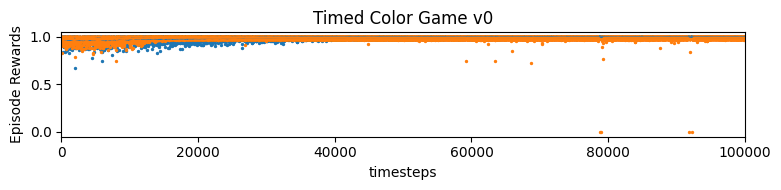

In [6]:
results = results_plotter.plot_results([mPPO_monitor_dir, mA2C_monitor_dir], num_timesteps=100000, x_axis='timesteps', task_name="Timed Color Game v0")

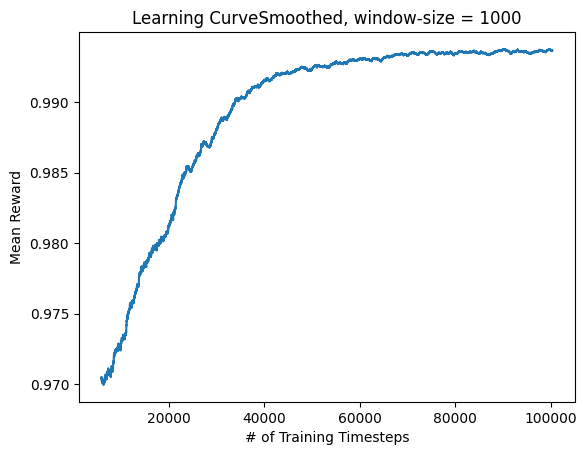

In [12]:
#I can't figure out a way to get the rolling-window line chart with the results_plotter, so for now let's go back
# to our custom function and plot that.

plot_results(mPPO_monitor_dir, window=1000)

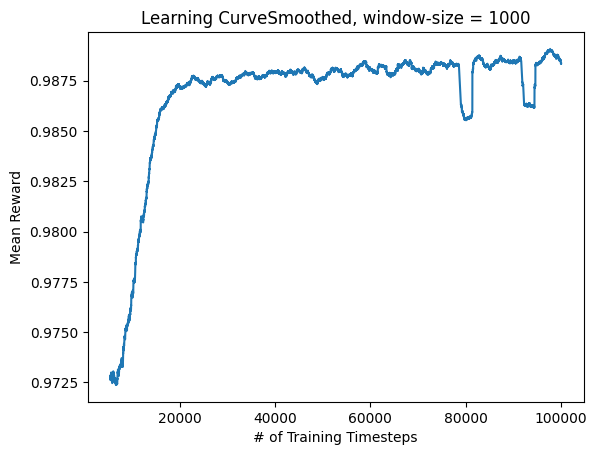

In [13]:
plot_results(mA2C_monitor_dir, window=1000)

Okay, we got the two individual windows pretty easily, now how to plot them in the same graph... I'm going to try defining a new function which takes an array of values as input and outputs a multi-model graph.

In [21]:
def plot_multi(log_folders, labels, window = 1000, title="Learning Curve "):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    
    fig = plt.figure(title)

    for i, log_folder in enumerate(log_folders):
        x, y = ts2xy(load_results(log_folder), "timesteps")
        y = moving_average(y, window=window)
        # Truncate x
        x = x[len(x) - len(y) :]
        plt.plot(x,y, label = labels[i])
    
    plt.xlabel("# of Training Timesteps")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.title(title + f"Smoothed, window-size = {window}")
    plt.show()

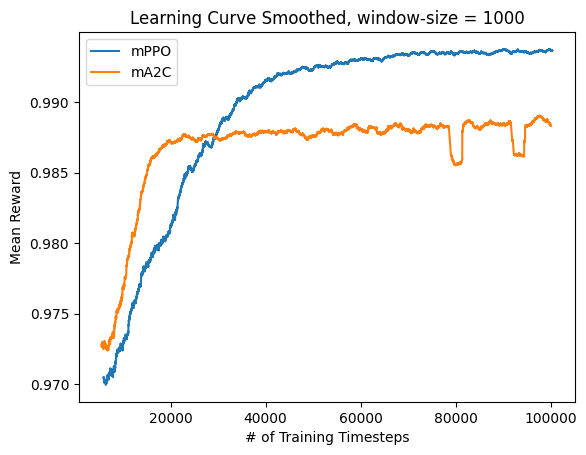

In [22]:
plot_multi([mPPO_monitor_dir, mA2C_monitor_dir], ["mPPO","mA2C"], window = 1000)

# Custom function worked better than the built-in plotting function

but that's fine. We're still taking advantage of the Monitor wrapper and the other tools used in the plotting function like txs2y. This function is just me copying the version that SB3 made in the tutorial and modifying it a bit. Presumably, they added the custom function section into the tutorial so future developers could do just this!